In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import importlib
import torch.optim as optim

import kagglehub
import data
import agente


importlib.reload(data)
importlib.reload(agente)

c:\Users\Adrian\anaconda3\envs\AA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'agente' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente.py'>

In [90]:
#Aqui habría que poner la linea de codigo para descargar el dataset
#El dataset tiene un par de fotos en los que el formato del nombre de la imagen esta mal; yo las he borrado directamente pero en google colab no se puedem borrar archivos
#por eso no he puesto el codigo de la descarga
#Cuando hagas pruebas tu carga el dataset entero en dataset = data.ImgDataset(utk_ruta,transform=transform) y cuando los tengas cargados quita las foto de dataset que den problemas
#Son aquellas que eran de la forma edad_año_fecha.jpg


In [2]:
#solo sirve en mi ordena ichi esta linea
utk_ruta = "C:\\Users\\Adrian\\.cache\\kagglehub\\datasets\\jangedoo\\utkface-new\\versions\\1\\UTKFace"

# Transformar dataset 
Transformamos las imagenes en una estructura de datos con la que podamos trabajar

In [3]:
#Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Esto normalizara las imagenes
dataset = data.ImgDataset(utk_ruta,transform=transform) #Pasamos las imagenes a la estructura de datos

GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negrata','Chinito','Indio','Otros')


In [4]:
# Crear los DataLoaders
train_dataloader,test_dataloader = data.entrenamientoTest(dataset=dataset,test_size=0.2,batch_size=4)

print(len(train_dataloader))
print(len(test_dataloader))

4741
1186


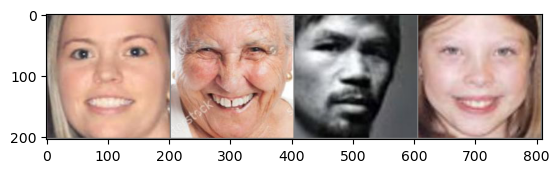

Edad:    22.0  85.0  30.0  15.0
Genero: Mujer Mujer Hombre Mujer
Raza:   Blanco Blanco Chinito Blanco


In [5]:
# Display image and label.
imagenes, edades,generos,razas = next(iter(train_dataloader))

# show images
data.mostrarImg(imagenes)
print('Edad:  ',' '.join('%5s' % edades[j].item() for j in range(4)))
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
print('Raza:  ',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))


# Modelo 1: Denzel Washington

Entrenaremos 3 modelos distintos, uno por cada objetivo que queremos predecir. 

Ambos modelos tendrán la misma estructura excepto en la ultima capa. 

Además el entrenamiento será distinto para cada uno de ellos pues utilizaremos distintos criterios y optimizadores segun el objetivo

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x




In [7]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


Creamos un agente con los 3 modelos siguientes:

In [8]:
#Modelo edad
DWEdad = DenzelWashington(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
DWGenero = DenzelWashington(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
DWRaza = DenzelWashington(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteDW = agente.Agente(modeloEdad=DWEdad,
                         modeloGenero=DWGenero,
                         modeloRaza=DWRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         epochs=150,
                         lr = 0.0001)


In [ ]:
#Entrenamos el agente
agenteDW.entrenarGenero(train_dataloader)
torch.save(agenteDW.modeloGenero.state_dict(), './DWGenero.pth')
agenteDW.entrenarEdad(train_dataloader)
torch.save(agenteDW.modeloEdad.state_dict(), './DWEdad.pth')
agenteDW.entrenarRaza(train_dataloader)
torch.save(agenteDW.modeloRaza.state_dict(), './DWRaza.pth')

In [9]:
agenteDW.modeloEdad.load_state_dict(torch.load('DWEdad1.pth'))
agenteDW.modeloGenero.load_state_dict(torch.load('DWGenero1.pth'))
agenteDW.modeloRaza.load_state_dict(torch.load('DWRaza.pth'))

<All keys matched successfully>

# Resultados

- Tasa aciertos

In [10]:
correct_edad = 0
correct_gen = 0
correct_raza = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch in test_dataloader:
        imagenes,edades,generos,razas = batch
        imagenes, edades, generos,razas = imagenes.to(device),edades.to(device),generos.to(device),razas.to(device)

        #Genero
        generosPred = agenteDW.modeloGenero(imagenes)
        _, generosPred = torch.max(generosPred, 1)

        correct_gen += (generosPred == generos).sum().item()

        #Edad
        edadesPred = agenteDW.modeloEdad(imagenes)
        correct_edad += (edades == edadesPred.squeeze().int()).sum().item()

        #Raza
        razasPred = agenteDW.modeloRaza(imagenes)
        _, razasPred = torch.max(razasPred, 1)
        correct_raza += (razas == razasPred).sum().item()

        
        total += generosPred.size(0)
        

print(f'Tasa aciertos de la red en {total} imagenes de test (Edad): {100 * correct_edad // total} %')
print(f'Tasa aciertos de la red en {total} imagenes de test (Genero): {100 * correct_gen // total} %')
print(f'Tasa aciertos de la red en {total} imagenes de test (Raza): {100 * correct_raza // total} %')

Tasa aciertos de la red en 4742 imagenes de test (Edad): 4 %
Tasa aciertos de la red en 4742 imagenes de test (Genero): 89 %
Tasa aciertos de la red en 4742 imagenes de test (Raza): 77 %


In [15]:
#La edad no es capaz de determinar la edad exacta ¿ pero cuanto se equivoca? Error absoluto medio  
error_total = 0
total = 0

#Calcula (valor real - valor prediccion) y hace la media 
with torch.no_grad():
    for batch in test_dataloader:
        imagenes,edades,_,_ = batch
        imagenes, edades = imagenes.to(device),edades.to(device)
        edadesPred = agenteDW.modeloEdad(imagenes)

        error_total += torch.abs(edades-edadesPred.squeeze().int()).sum().item() 
        
        total += edades.size(0)
        

print(f'Error absoluto medio(Edad): {error_total / total}') #Margen de 7 años de media


Error absoluto medio(Edad): 7.61008013496415


- Matriz confusion

In [17]:
torch.tensor([])

tensor([])

In [ ]:
# since we're not training, we don't need to calculate the gradients for our outputs
generosPred = torch.tensor([])
edadesPred = torch.tensor([])
razasPred = torch.tensor([])

with torch.no_grad():
    for batch in test_dataloader:

        imagenes,edades,generos,razas = batch
        imagenes, edades, generos,razas = imagenes.to(device),edades.to(device),generos.to(device),razas.to(device)

        #Genero
        generosPred = agenteDW.modeloGenero(imagenes)
        _, generosPred = torch.max(generosPred, 1)

        correct_gen += (generosPred == generos).sum().item()

        #Edad
        edadesPred = agenteDW.modeloEdad(imagenes)
        correct_edad += (edades == edadesPred.squeeze().int()).sum().item()

        #Raza
        razasPred = agenteDW.modeloRaza(imagenes)
        _, razasPred = torch.max(razasPred, 1)
        correct_raza += (razas == razasPred).sum().item()

        
        total += generosPred.size(0)

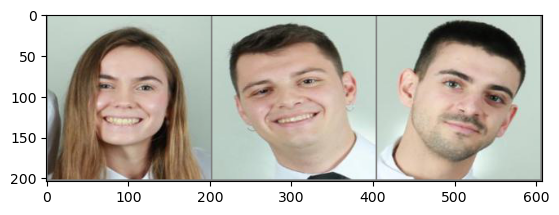

Valor real
Genero: Mujer Hombre Hombre
Predicciones
Genero: Mujer Hombre Hombre
Edad: 34.8201789855957 52.45399475097656 38.23067092895508


In [16]:
tempusFugit = data.ImgDataset("./fotos",transform=transform)
imagenes = [imagen for imagen, _, _,_ in tempusFugit ]
generos = [genero for _,_, genero,_ in tempusFugit]

imagenes = torch.stack(imagenes,dim = 0)
generos = torch.stack(generos,dim=0)

imagenes = imagenes.to(device)

data.mostrarImg(imagenes)
predicciones = agenteDW.modeloGenero(imagenes)
edades = agenteDW.modeloEdad(imagenes)    
_, generosPred = torch.max(predicciones, 1)

print("Valor real")
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(3)))
print("Predicciones")
print('Genero:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(3)))
print('Edad:',' '.join('%5s' % edades[j].item() for j in range(3)))
